# Place Recommendation System

This notebook implements a recommendation system for tourist places in Cambodia using:
- **Content-Based Filtering (CBF)**: Recommends places based on user preferences and similar places
- **Collaborative Filtering (CF)**: Recommends places based on user similarity

Following the structure of the book recommendation system example.


# Import libraries


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')


In [99]:
# Add workspace to Python path
import sys
import os

# Get the notebook's directory
notebook_dir = os.getcwd()
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)
    print(f"Added to path: {notebook_dir}")

# Data Understanding

Here are some steps to understand data:
- Data Loading
- Univariate Exploratory Data Analysis
- Data Preprocessing


# ==> Data Loading

In this section, the dataset will be read directly from the data folder. We have the places dataset and will generate synthetic user rating data for collaborative filtering.


## Load the dataset


In [100]:
# Load places dataset
import sys
import os

# Ensure workspace is in path and set working directory
workspace = '/home/cham/Desktop/DerTam/SmartTourism'
if workspace not in sys.path:
    sys.path.insert(0, workspace)
os.chdir(workspace)

from recommendation_system.data_loader import load_places_dataset, preprocess_places_data, generate_synthetic_ratings

places = load_places_dataset('data/dataset_with_descriptions_cleaned.csv')
print(f'Number of places: {len(places)}')
print(f'Number of unique places: {len(places.placeID.unique())}')

Number of places: 3987
Number of unique places: 3446


In [101]:
# Display dataset info
places.head()


,placeID,name,google_maps_link,images_url,province_id,province_name,latitude,longitude,category_id,category_name,ratings,reviews_count,description
0,ChIJ42tqxz1RCTER36bOGZOA8fg,Royal Palace of Cambodia,https://www.google.com/maps/place/?q=place_id:...,['https://maps.googleapis.com/maps/api/place/p...,1,Phnom Penh,11.563877,104.931252,1,Tourist Attraction,4.3,12506.0,Royal Palace of Cambodia is a popular tourist ...
1,ChIJw8jeJSJRCTERp9gvbl8l0hM,Tuol Sleng Genocide Museum,https://www.google.com/maps/place/?q=place_id:...,['https://maps.googleapis.com/maps/api/place/p...,1,Phnom Penh,11.548851,104.917675,1,Tourist Attraction,4.6,11655.0,Tuol Sleng Genocide Museum is a popular touris...
2,ChIJEfPby0RRCTERZOuHF6zhiCU,Wat Phnom Daun Penh,https://www.google.com/maps/place/?q=place_id:...,['https://maps.googleapis.com/maps/api/place/p...,1,Phnom Penh,11.576148,104.923094,1,Tourist Attraction,4.4,8646.0,Wat Phnom Daun Penh is a popular tourist attra...
3,ChIJnXoiJEhRCTERJadKK31Dvrg,National Museum of Cambodia,https://www.google.com/maps/place/?q=place_id:...,['https://maps.googleapis.com/maps/api/place/p...,1,Phnom Penh,11.565854,104.929146,1,Tourist Attraction,4.1,6478.0,National Museum of Cambodia is a popular touri...
4,ChIJ42tqxz1RCTERsG1wcg9Cxeo,Independence Monument,https://www.google.com/maps/place/?q=place_id:...,['https://maps.googleapis.com/maps/api/place/p...,1,Phnom Penh,11.556434,104.928204,1,Tourist Attraction,4.5,4894.0,Independence Monument is a popular tourist att...


In [102]:
places.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   placeID           3987 non-null   object 
 1   name              3987 non-null   object 
 2   google_maps_link  3987 non-null   object 
 3   images_url        3987 non-null   object 
 4   province_id       3987 non-null   int64  
 5   province_name     3987 non-null   object 
 6   latitude          3987 non-null   float64
 7   longitude         3987 non-null   float64
 8   category_id       3987 non-null   int64  
 9   category_name     3987 non-null   object 
 10  ratings           3987 non-null   float64
 11  reviews_count     3987 non-null   float64
 12  description       3987 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 405.1+ KB


# ==> Univariate Exploratory Data Analysis


## Places Variable


In [103]:
# Check places dataset information
print(f'Total places: {len(places)}')
print(f'Unique place IDs: {places.placeID.nunique()}')
print(f'\nColumns: {places.columns.tolist()}')
print(f'\nMissing values:')
print(places.isnull().sum())


Total places: 3987
Unique place IDs: 3446

Columns: ['placeID', 'name', 'google_maps_link', 'images_url', 'province_id', 'province_name', 'latitude', 'longitude', 'category_id', 'category_name', 'ratings', 'reviews_count', 'description']

Missing values:
placeID             0
name                0
google_maps_link    0
images_url          0
province_id         0
province_name       0
latitude            0
longitude           0
category_id         0
category_name       0
ratings             0
reviews_count       0
description         0
dtype: int64


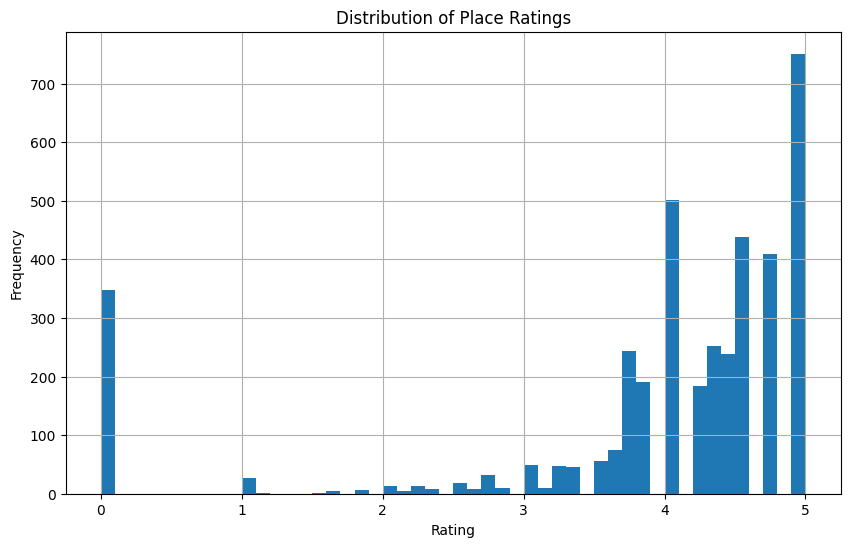

In [104]:
# Ratings distribution
plt.figure(figsize=(10, 6))
places['ratings'].hist(bins=50)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Place Ratings')
plt.show()


## Ratings Variable (Synthetic)

Since we don't have actual user ratings, we'll generate synthetic rating data for collaborative filtering.


In [105]:
# Load existing ratings from CSV
places_processed = preprocess_places_data(places)
ratings = pd.read_csv('data/ratings.csv')

print(f'Total ratings: {len(ratings)}')
print(f'Number of users: {ratings.user_id.nunique()}')
print(f'Number of places rated: {ratings.place_id.nunique()}')
ratings.head()

Total ratings: 83180
Number of users: 3000
Number of places rated: 3438


,user_id,place_id,rating
0,1,ChIJEzfyJLKDETER9zd31-o84JA,0.801505
1,1,ChIJ32YQh9lLBTERgapKOe8oAaM,0.951585
2,1,ChIJ23D2MDt2CTERWBj20dtGLrI,0.825758
3,1,ChIJwzI7l8NRCTER6BBveyJFbgQ,0.808176
4,1,ChIJJSWZa3prDDER92o3N3pWUlQ,0.843088


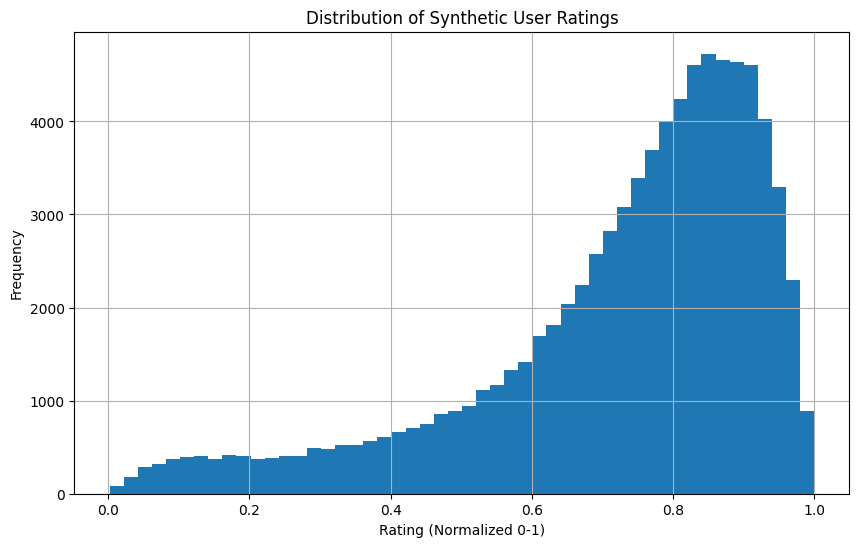

In [106]:
# Ratings distribution
plt.figure(figsize=(10, 6))
ratings['rating'].hist(bins=50)
plt.xlabel('Rating (Normalized 0-1)')
plt.ylabel('Frequency')
plt.title('Distribution of Synthetic User Ratings')
plt.show()


## Users Variable (Synthetic)


In [107]:
# User statistics
print(f'Total users: {ratings.user_id.nunique()}')
print(f'Average ratings per user: {ratings.groupby("user_id").size().mean():.2f}')
print(f'Min ratings per user: {ratings.groupby("user_id").size().min()}')
print(f'Max ratings per user: {ratings.groupby("user_id").size().max()}')


Total users: 3000
Average ratings per user: 27.73
Min ratings per user: 5
Max ratings per user: 50


# ==> Data Preprocessing


## Merging Files and Determining the Total Number of Ratings


In [108]:
# Merge places with ratings
df_rating = ratings.merge(places_processed[['placeID', 'name', 'category_name', 'ratings', 'reviews_count']], 
                          left_on='place_id', right_on='placeID', how='left')

print(f'Total rating records: {len(df_rating)}')
print(f'Unique users: {df_rating.user_id.nunique()}')
print(f'Unique places: {df_rating.place_id.nunique()}')
df_rating.head()


Total rating records: 83180
Unique users: 3000
Unique places: 3438


,user_id,place_id,rating,placeID,name,category_name,ratings,reviews_count
0,1,ChIJEzfyJLKDETER9zd31-o84JA,0.801505,ChIJEzfyJLKDETER9zd31-o84JA,Tra Caf'e Food & Drink,Restaurant,5.0,2.0
1,1,ChIJ32YQh9lLBTERgapKOe8oAaM,0.951585,ChIJ32YQh9lLBTERgapKOe8oAaM,Rx'd Cafe and Restaurant,Restaurant,4.9,149.0
2,1,ChIJ23D2MDt2CTERWBj20dtGLrI,0.825758,ChIJ23D2MDt2CTERWBj20dtGLrI,Mittapheap,Hotel,4.1,11.0
3,1,ChIJwzI7l8NRCTER6BBveyJFbgQ,0.808176,ChIJwzI7l8NRCTER6BBveyJFbgQ,Hotel,Hotel,5.0,1.0
4,1,ChIJJSWZa3prDDER92o3N3pWUlQ,0.843088,ChIJJSWZa3prDDER92o3N3pWUlQ,នំបញ្ចុកខួរក្តាម​ ម៉ាក់លីដា​,Restaurant,4.7,3.0


# ==> Data Preparation for Model Development with Content-Based Filtering


## Handling Missing Value


In [109]:
# Handle missing values for CBF
places_cbf = places_processed.copy()
places_cbf['description'] = places_cbf['description'].fillna('')
places_cbf['category_name'] = places_cbf['category_name'].fillna('')
places_cbf['name'] = places_cbf['name'].fillna('')

print(f'Places after handling missing values: {len(places_cbf)}')
print(f'Missing values: {places_cbf[["description", "category_name", "name"]].isnull().sum().sum()}')


Places after handling missing values: 3446
Missing values: 0


## Standardizing Place Types Based on placeID


In [110]:
# Ensure placeID is unique and standardized
places_cbf = places_cbf.drop_duplicates(subset=['placeID'])
places_cbf = places_cbf.dropna(subset=['placeID'])

print(f'Unique places: {places_cbf.placeID.nunique()}')
print(f'Total places: {len(places_cbf)}')


Unique places: 3446
Total places: 3446


# ==> Model Development with Content-Based Filtering

In this stage, a model will be developed using the Content-Based Filtering technique. Content-Based Filtering is an approach in recommendation systems that utilizes information or "content" from items to make recommendations. The basic idea is to match user preferences with the characteristics or content of items.

In the model development process, the search for important feature representations of each place is performed using the TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer. The TF-IDF vectorizer is a tool used to convert text documents into vector representations based on the TF-IDF values of each word in the document.

Meanwhile, to calculate the similarity degree between places, the cosine similarity technique is used. This method is used to measure the similarity between two vectors in a high-dimensional space.


## TF-IDF Vectorizer


In [111]:
# Combine text features
combined_text = places_cbf[['description', 'category_name', 'name']].apply(
    lambda x: ' '.join(x.astype(str)), axis=1
)

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer()

# Fit and transform
tfidf_matrix = tfidf.fit_transform(combined_text)

print(f'TF-IDF matrix shape: {tfidf_matrix.shape}')
print(f'Number of features: {len(tfidf.get_feature_names_out())}')

TF-IDF matrix shape: (3446, 3395)
Number of features: 3395


In [112]:
# Create DataFrame for visualization
# Convert sparse matrix to dense (note: this can be memory-intensive for large datasets)
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=places_cbf['placeID'],  # Use placeID as index
    columns=tfidf.get_feature_names_out()  # Use feature names (words) as columns
)

print(f'\nTF-IDF DataFrame created:')
print(f'Shape: {tfidf_df.shape}')
print(f'Index (places): {tfidf_df.index.name or "placeID"}')
print(f'Columns (features): {len(tfidf_df.columns)} word features')
print(f'\nFirst few rows and columns:')
tfidf_df.head()


TF-IDF DataFrame created:
Shape: (3446, 3395)
Index (places): placeID
Columns (features): 3395 word features

First few rows and columns:


,011,02,03,05,101,103,105,10កម,120,1200,...,西港店,西港洲际,西港网点,诺蒂斯国际酒店,金边新都汇国际大酒店,金边金界旗舰店,강남스타일,시하누크빌,홍콩반점,𝕽𝖊𝖑𝖆𝖝
placeID,,,,,,,,,,,,,,,,,,,,,
ChIJ42tqxz1RCTER36bOGZOA8fg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ChIJw8jeJSJRCTERp9gvbl8l0hM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ChIJEfPby0RRCTERZOuHF6zhiCU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ChIJnXoiJEhRCTERJadKK31Dvrg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ChIJ42tqxz1RCTERsG1wcg9Cxeo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cosine Similarity


In [113]:
# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

print(f'Cosine similarity matrix shape: {cosine_sim.shape}')

# Create DataFrame for easier lookup
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=places_cbf['placeID'],
    columns=places_cbf['placeID']
)

cosine_sim_df.head()


Cosine similarity matrix shape: (3446, 3446)


placeID,ChIJ42tqxz1RCTER36bOGZOA8fg,ChIJw8jeJSJRCTERp9gvbl8l0hM,ChIJEfPby0RRCTERZOuHF6zhiCU,ChIJnXoiJEhRCTERJadKK31Dvrg,ChIJ42tqxz1RCTERsG1wcg9Cxeo,ChIJyZ59w2VaCTER07FCdaW0gMc,ChIJL0U7ZzZRCTERU_d4vGDBBAo,ChIJqUiG40lRCTERO91s5YjVEoY,ChIJ5zPaEU9RCTER_E-SnOofV1Q,ChIJgybaVDBRCTERxlRrWou-GSg,...,ChIJu2AwI0XjCzERhh0EfXtLgp8,ChIJF8tgp5VjDDERvAYWXESVO-U,ChIJDQd53RFjCTERPmxFOujAfiE,ChIJ5Y9tIQCxDjER-f3dWHerrOM,ChIJ4cgeyCtGCTERm6FPipSMf3Q,ChIJJ64KpwCGDDER3C5EB0E3w9o,ChIJgx2rRWCJDDER8g5r17ZucfY,ChIJK_DuAKxRCTERRx6X9RhF1UM,ChIJq__q8c5FCTERLjk6iU-VNXg,ChIJk9Fv_RiJDDER7I6HYJwdnOo
placeID,,,,,,,,,,,,,,,,,,,,,
ChIJ42tqxz1RCTER36bOGZOA8fg,1.000000,0.133099,0.240661,0.498677,0.195684,0.134670,0.197552,0.717477,0.169665,0.200884,...,0.019124,0.032658,0.028983,0.026313,0.083945,0.058798,0.028158,0.021998,0.028898,0.028751
ChIJw8jeJSJRCTERp9gvbl8l0hM,0.133099,1.000000,0.186758,0.324456,0.151855,0.104506,0.153305,0.144170,0.131663,0.074419,...,0.014841,0.025343,0.022491,0.020419,0.065143,0.045628,0.021851,0.017071,0.022426,0.022311
ChIJEfPby0RRCTERZOuHF6zhiCU,0.240661,0.186758,1.000000,0.235718,0.274574,0.188962,0.277196,0.260680,0.238065,0.134560,...,0.018517,0.031621,0.028063,0.025478,0.081281,0.056932,0.027264,0.021300,0.027981,0.027838
ChIJnXoiJEhRCTERJadKK31Dvrg,0.498677,0.324456,0.235718,1.000000,0.191664,0.131903,0.193494,0.181966,0.166179,0.196757,...,0.018731,0.031987,0.028387,0.025773,0.082220,0.057590,0.027579,0.021546,0.028305,0.028160
ChIJ42tqxz1RCTERsG1wcg9Cxeo,0.195684,0.151855,0.274574,0.191664,1.000000,0.153647,0.225390,0.211961,0.193573,0.109412,...,0.021819,0.037260,0.033067,0.030021,0.095774,0.067083,0.032125,0.025097,0.032970,0.032802


## Getting Recommendations


In [114]:
def place_recommendation(place_name, similarity_data=cosine_sim_df, items=places_cbf[['placeID', 'name', 'category_name']], k=5):
    """
    Get recommendations for a place.
    
    Args:
        place_name: Name of the place
        similarity_data: DataFrame with similarity scores
        items: DataFrame with place details
        k: Number of recommendations
        
    Returns:
        DataFrame with recommended places
    """
    # Find place ID by name
    place_row = items[items['name'] == place_name]
    if len(place_row) == 0:
        return pd.DataFrame()
    
    place_id = place_row.iloc[0]['placeID']
    
    if place_id not in similarity_data.index:
        return pd.DataFrame()
    
    # Get similarity scores
    similarity_scores = similarity_data.loc[place_id].sort_values(ascending=False)
    similarity_scores = similarity_scores.drop(place_id, errors='ignore')
    
    # Get top k
    top_k_indices = similarity_scores.head(k).index
    
    # Get place details
    recommended = items[items['placeID'].isin(top_k_indices)].copy()
    recommended['similarity_score'] = recommended['placeID'].map(similarity_scores.to_dict())
    recommended = recommended.sort_values('similarity_score', ascending=False)
    
    return recommended.head(k)


In [115]:
# Test recommendation
if len(places_cbf) > 0:
    test_place = places_cbf.iloc[0]['name']
    print(f"Getting recommendations for: {test_place}")
    recommendations = place_recommendation(test_place, k=5)
    print(f"\nTop 5 recommendations:")
    print(recommendations[['name', 'category_name', 'similarity_score']])


Getting recommendations for: Royal Palace of Cambodia

Top 5 recommendations:
                            name       category_name  similarity_score
7              Royal Palace Park  Tourist Attraction          0.717477
236              Royal Residence  Tourist Attraction          0.500825
3    National Museum of Cambodia  Tourist Attraction          0.498677
511                  Royal Hotel               Hotel          0.444026
226   Royal Independence Gardens  Tourist Attraction          0.386276


# ==> Model Development with Collaborative Filtering

In this model development process, collaborative filtering technique will be applied to create a recommendation system. This technique requires user rating data. Collaborative filtering is one of the methods in recommendation systems that predicts user preferences for items based on information from other users (collaboration).

The development of the collaborative filtering model will result in recommendations for places that match the user's preferences based on previously given ratings.


## Splitting Data for Training and Validation


In [116]:
# Prepare data for CF
# Create user and place mappings
unique_users = sorted(df_rating['user_id'].unique())
unique_places = sorted(df_rating['place_id'].unique())

user_to_index = {user: idx for idx, user in enumerate(unique_users)}
place_to_index = {place: idx for idx, place in enumerate(unique_places)}

num_users = len(unique_users)
num_places = len(unique_places)

print(f'Number of users: {num_users}')
print(f'Number of places: {num_places}')

# Encode ratings
df_rating_encoded = df_rating.copy()
df_rating_encoded['user'] = df_rating_encoded['user_id'].map(user_to_index)
df_rating_encoded['place'] = df_rating_encoded['place_id'].map(place_to_index)

# Prepare x and y
x = df_rating_encoded[['user', 'place']].values
y = df_rating_encoded['rating'].values

# Normalize ratings (already 0-1, but ensure)
min_rating = y.min()
max_rating = y.max()
if max_rating > min_rating:
    y = (y - min_rating) / (max_rating - min_rating)

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')
print(f'Y range: [{y.min():.2f}, {y.max():.2f}]')


Number of users: 3000
Number of places: 3438
X shape: (83180, 2)
Y shape: (83180,)
Y range: [0.00, 1.00]


In [117]:
# Shuffle and split data
indices = np.arange(len(x))
np.random.seed(42)
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Split 90% train, 10% validation
train_indices = int(0.9 * len(x))
x_train, x_val = x[:train_indices], x[train_indices:]
y_train, y_val = y[:train_indices], y[train_indices:]

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')


Training samples: 74862
Validation samples: 8318


## Training Process


In [118]:
# Define RecommenderNet class
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_places, embedding_size, dropout_rate=0.2, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_places = num_places
        self.embedding_size = embedding_size
        self.dropout_rate = dropout_rate
        
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        
        self.place_embedding = layers.Embedding(
            num_places,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.place_bias = layers.Embedding(num_places, 1)
        
        self.dropout = layers.Dropout(rate=dropout_rate)
    
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_vector = self.dropout(user_vector)
        user_bias = self.user_bias(inputs[:, 0])
        
        place_vector = self.place_embedding(inputs[:, 1])
        place_vector = self.dropout(place_vector)
        place_bias = self.place_bias(inputs[:, 1])
        
        dot_user_place = tf.tensordot(user_vector, place_vector, 2)
        x = dot_user_place + user_bias + place_bias
        
        return tf.nn.sigmoid(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_users": self.num_users,
            "num_places": self.num_places,
            "embedding_size": self.embedding_size,
            "dropout_rate": self.dropout_rate,
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [119]:
# Initialize and compile model
model = RecommenderNet(num_users, num_places, 50)

model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

print("Model compiled successfully!")


Model compiled successfully!


In [120]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=10,
    validation_data=(x_val, y_val)
)


Epoch 1/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6912 - root_mean_squared_error: 0.3048 - val_loss: 0.6879 - val_root_mean_squared_error: 0.2994
Epoch 2/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6578 - root_mean_squared_error: 0.2761 - val_loss: 0.6828 - val_root_mean_squared_error: 0.2951
Epoch 3/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6314 - root_mean_squared_error: 0.2516 - val_loss: 0.6776 - val_root_mean_squared_error: 0.2907
Epoch 4/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6114 - root_mean_squared_error: 0.2318 - val_loss: 0.6721 - val_root_mean_squared_error: 0.2860
Epoch 5/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5973 - root_mean_squared_error: 0.2173 - val_loss: 0.6663 - val_root_mean_squared_error: 0.2809
Epoch 6/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5889 - root_mean_squared_error: 0.2088 - val_loss: 0.6609 - val_root_mean_squared_error: 0.2760
Epoch 7/10
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step 

## Getting Place Recommendations


In [121]:
# Get recommendations for a user
user_id = 1
user_encoded = user_to_index.get(user_id)

if user_encoded is not None:
    # Get places user has rated
    user_ratings = df_rating_encoded[df_rating_encoded['user'] == user_encoded]
    places_rated = user_ratings['place_id'].unique()
    
    # Get places not rated
    places_not_rated = [p for p in unique_places if p not in places_rated]
    
    # Predict ratings for unrated places
    place_encodings = [place_to_index[p] for p in places_not_rated[:100]]  # Limit for speed
    x_user = np.array([[user_encoded, p_enc] for p_enc in place_encodings])
    
    ratings_model = model.predict(x_user, verbose=0).flatten()
    
    # Get top recommendations
    top_ratings_indices = ratings_model.argsort()[-10:][::-1]
    recommended_place_ids = [places_not_rated[i] for i in top_ratings_indices]
    
    # Display recommendations
    print(f"Top 10 recommendations for user {user_id}:")
    recommendations_df = places_processed[places_processed['placeID'].isin(recommended_place_ids)]
    for idx, row in recommendations_df.iterrows():
        print(f"- {row['name']} (Rating: {row['ratings']:.1f})")
else:
    print(f"User {user_id} not found in dataset")


Top 10 recommendations for user 1:
- Garden City Water Park (Rating: 4.4)
- Mealea Restaurant (Rating: 4.6)
- Wat Bo (Rating: 4.5)
- Ek Phnom Pagoda (Rating: 4.3)
- Social Restaurant & Rooftop Bar (Rating: 4.8)
- HLH Express - Sihanoukville (Rating: 5.0)
- បាយត្រីចៀនកំពង់ចាម (តាវណ្ណា) (Rating: 4.3)
- Sopheak Mangkol Canteen (Rating: 4.6)
- AVT - Asia Van Transfer - Hout (Rating: 4.0)
- Boeung Meas Svay Rieng (Rating: 4.1)


# ==> Model Evaluation with Content-Based Filtering


In [122]:
# CBF Evaluation
# For simplicity, we'll evaluate based on similarity scores
# In a real scenario, you would use actual user feedback

# Sample evaluation: check if recommendations have high similarity
test_place = places_cbf.iloc[0]
recommendations = place_recommendation(test_place['name'], k=10)

if len(recommendations) > 0:
    # Calculate metrics (simplified)
    avg_similarity = recommendations['similarity_score'].mean()
    print(f"Average similarity score: {avg_similarity:.4f}")
    print(f"Min similarity: {recommendations['similarity_score'].min():.4f}")
    print(f"Max similarity: {recommendations['similarity_score'].max():.4f}")
    
    # For binary classification evaluation (simplified)
    # Assume recommendations with similarity > 0.5 are relevant
    y_true = np.ones(len(recommendations))  # All recommendations are considered relevant
    y_pred = (recommendations['similarity_score'] > 0.5).astype(int)
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\nCBF Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


Average similarity score: 0.4325
Min similarity: 0.3419
Max similarity: 0.7175

CBF Evaluation Metrics:
Precision: 1.0000
Recall: 0.2000
F1-Score: 0.3333


# ==> Model Evaluation with Collaborative Filtering


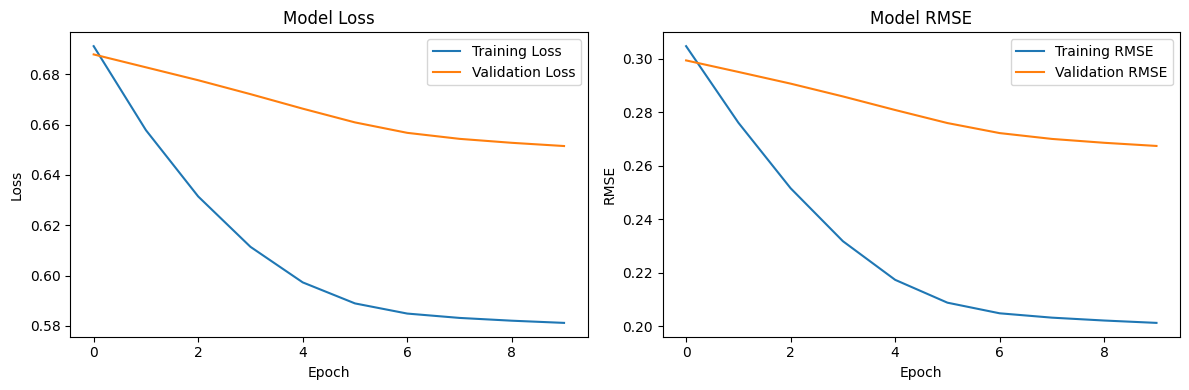

In [123]:
# Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Model RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [124]:
# Final evaluation metrics
final_train_rmse = history.history['root_mean_squared_error'][-1]
final_val_rmse = history.history['val_root_mean_squared_error'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("CF Model Evaluation Results:")
print(f"Training RMSE: {final_train_rmse:.4f}")
print(f"Validation RMSE: {final_val_rmse:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")


CF Model Evaluation Results:
Training RMSE: 0.2012
Validation RMSE: 0.2674
Training Loss: 0.5812
Validation Loss: 0.6515


In [125]:
# Save models
import os
os.makedirs('models/cf_model', exist_ok=True)

# Save CBF model
from recommendation_system.cbf_recommender import CBFRecommender
cbf_model = CBFRecommender()
cbf_model.fit(places_cbf)
cbf_model.save_model('models/cbf_model.pkl')
print("CBF model saved!")

# Save CF model (using modern .keras format)
model.save('models/cf_model/model.keras')
import pickle
mappings = {
    'user_to_index': user_to_index,
    'place_to_index': place_to_index,
    'num_users': num_users,
    'num_places': num_places
}
with open('models/cf_model/mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)
print("CF model saved!")

CBF model saved!
CF model saved!
